# Advanced data reduction

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os, glob
# from redcross import Datacube

import sys
sys.path.append('/home/dario/AstronomyLeiden/MRP/redcross/src/')
from redcross.datacube import Datacube
from redcross import read_harpsn
from redcross import Pipeline



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading instrument files
Let's read the instrument's pipeline FITS files for each spectrum and create a `Datacube` instance with the correct formatting. In this example we place HARPS-N `e2ds` files in one folder `data_dir`.

In [2]:
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/e2ds/night1'
files = sorted(glob.glob(os.path.join(data_dir, '*.fits'))) # IMPORTANT: sort the files
print('{:} files found!'.format(len(files)))

247 files found!


For HARPS-N, we use the in-built function `read_harpsn`. At this stage you may want to define your own function to 
read the *wavelength*, *flux* and the *header* of each frame. The header must be a dictionary and can be passed as a kwarg argument i.e. `dc = Datacube(**header)`. The header keys will automatically be stored as attributes.

In [5]:
dc = read_harpsn(files)
print('{:} orders, {:} files, {:} pixel channels\n'.format(*dc.shape))

In [39]:
dc.wlt.shape

(69, 4096)

### Wavelength solution
Most instrument's pipelines provide a wavelength solution (WS) stored as a vector or as a polynomial in the FITS file. For this example, we take the **WS of each order as the time-average of all the frames** for that order. This works well for *ultra*-stabilised instruments but additional steps to refine the WS might be necessary in some cases.

In [37]:
print('Original wavelength vector shape = {:}'.format(dc.wlt.shape))
dc.wlt = np.median(dc.wlt, axis=1)
print('NEW wavelength vector shape = {:}'.format(dc.wlt.shape))


Original wavelength vector shape = 69
NEW wavelength vector shape = 69


### Header parameters
The header parameters are optional but it is recommended to pass them when creating the `datacube` instance. Some tools like `airmass_detrend` will only work with required header parameters (airmass).

dict_keys(['flux', 'wlt', 'flux_err', 'night', 'airmass', 'MJD', 'BERV', 'RA_DEG', 'DEC_DEG', 'DATE'])


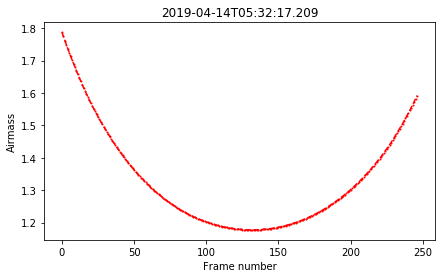

In [33]:
print(vars(dc).keys())
fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(dc.airmass, '--or', ms=1.)
ax.set(title=dc.DATE, xlabel='Frame number', ylabel='Airmass')
plt.show()

### Reduction pipeline for a single-order
We use the `Pipeline` object to define a set of reduction steps and apply them to every order. First, we play around with the routine by displaying the step-by-step process for a given order. Steps can also be added individually and arguments to the functions can be passed as dictionaries.

0
** Exit at iteration 1 **
--> 11.77 % of pixels masked <--


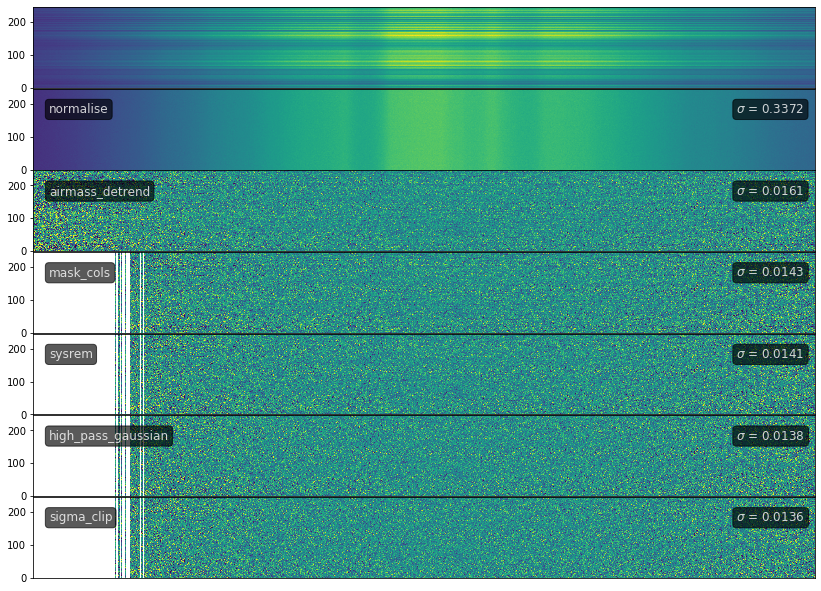

In [60]:
steps = ['normalise','airmass_detrend']
pipeline = Pipeline(steps)

# Add functions with arguments
pipeline.add('mask_cols', {'sigma':1.2, 'mode':'flux'}) 
pipeline.add('sysrem', {'n':3})
pipeline.add('high_pass_gaussian', {'window':15})
pipeline.add('sigma_clip', {'sigma':3}) 

n = len(steps)+1
fig, ax = plt.subplots(n, figsize=(14, n*1.5))
plt.subplots_adjust(hspace=0.01)
[ax[k].set_xticks([]) for k in range(n)]

# Call the Pipeline object to a given order
# pass `ax` to display every step (with len(ax) = len(steps)+1))
pipeline.reduce(dc.order(42), ax=ax)